In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import zscore, pearsonr, spearmanr

In [2]:
Fastq_samples = pd.read_csv("../code/config/samples.tsv", sep='\t', comment='#')
igsr_samples = pd.read_csv('../data/igsr_samples.tsv.gz', sep='\t', index_col=0)

polyA_samples = Fastq_samples.loc[Fastq_samples.Phenotype == 'Expression.Splicing'].IndID
YRI_samples = igsr_samples.loc[igsr_samples['Population code'] == 'YRI'].index

temp = '../code/QTLs/QTLTools/{Phenotype}/OnlyFirstRepsBasicUnstandardized.qqnorm.bed.gz'
temp_ = '../code/QTLs/QTLTools/{Phenotype}/OnlyFirstRepsUnstandardized.qqnorm.bed.gz'


polyA = pd.read_csv(temp.format(Phenotype = 'Expression.Splicing'), sep='\t', index_col=3)
chRNA = pd.read_csv(temp.format(Phenotype = 'chRNA.Expression.Splicing'), sep='\t', index_col=3)
ml30 = pd.read_csv(temp.format(Phenotype = 'MetabolicLabelled.30min'), sep='\t', index_col=3)
ml60 = pd.read_csv(temp.format(Phenotype = 'MetabolicLabelled.60min'), sep='\t', index_col=3)

h3k36me3 = pd.read_csv("../code/QTLs/QTLTools/H3K36ME3/OnlyFirstRepsUnstandardized.qqnorm.bed.gz", 
                       sep='\t', index_col=3)


temp = '../code/QTLs/QTLTools/{Phenotype}/OnlyFirstRepsUnstandardized_AtTSS.qqnorm.bed.gz'
h3k27ac = pd.read_csv(temp.format(Phenotype = 'H3K27AC'), sep='\t', index_col=3)
h3k4me3 = pd.read_csv(temp.format(Phenotype = 'H3K4ME3'), sep='\t', index_col=3)
h3k4me1 = pd.read_csv(temp.format(Phenotype = 'H3K4ME1'), sep='\t', index_col=3)


In [3]:
shared_samples = h3k36me3.columns.intersection(YRI_samples).intersection(h3k4me3.columns).intersection(
    h3k27ac.columns).intersection(polyA.columns).intersection(chRNA.columns).intersection(
    ml30.columns).intersection(h3k36me3.columns)
expressed_genes = polyA.loc[polyA[polyA.columns[5:]].median(axis=1) > -2].index

In [4]:
all_RNAs = pd.Index(expressed_genes).intersection(ml30.index).intersection(ml60.index).intersection(h3k36me3.index) 

polyA_samples = polyA.columns.intersection(YRI_samples)
polyA_logRPKM = polyA.loc[all_RNAs, shared_samples]
polyA_logRPKM.columns = ['polyA.' + x for x in shared_samples]

chRNA_samples = chRNA.columns.intersection(YRI_samples)
chRNA_logRPKM = chRNA.loc[all_RNAs, shared_samples]
chRNA_logRPKM.columns = ['chRNA.' + x for x in shared_samples]

# ml60_samples = ml60.columns.intersection(YRI_samples)
# ml60_logRPKM = ml60.loc[all_RNAs, shared_samples]
# ml60_logRPKM.columns = ['ml60.' + x for x in shared_samples]

ml30_samples = ml30.columns.intersection(YRI_samples)
ml30_logRPKM = ml30.loc[all_RNAs, shared_samples]
ml30_logRPKM.columns = ['ml30.' + x for x in shared_samples]

h3k36me3_samples = h3k36me3.columns.intersection(YRI_samples)
h3k36me3_logRPKM = h3k36me3.loc[all_RNAs, shared_samples]
h3k36me3_logRPKM.columns = ['h3k36me3.' + x for x in shared_samples]


H3K4ME3_TSS = pd.read_csv('../code/featureCounts/H3K4ME3/Counts.txt',
                                 sep='\t', skiprows = 1)
H3K4ME3_names = [x.split('ME3/')[1].split('.1')[0] for x in H3K4ME3_TSS.columns if ('Alignments' in x)]

H3K4ME3 = pd.read_csv('../code/QTLs/QTLTools/H3K4ME3/CountsPeaksAtTSS.bed.gz', 
                      sep='\t',
                     names = ['chrom', 'start', 'end', 'transcript_id', 'ensembl_id', 'strand',
                             'gene_id', 'chrom_', 'start_', 'end_', 'peak_id', 'peak_len',
                             'strand_'] + H3K4ME3_names + ['overlap_len'])
                     
H3K4ME3_samples = H3K4ME3.columns.intersection(shared_samples)
H3K4ME3 = H3K4ME3.groupby(['ensembl_id', 'peak_id']).max()
H3K4ME3_counts = H3K4ME3.groupby('ensembl_id')[H3K4ME3_samples].sum()
h3k4me3_CPM = H3K4ME3_counts.divide(H3K4ME3_counts.sum(axis=0), axis=1)*1e6

h3k4me3_CPM = h3k4me3_CPM.loc[h3k4me3_CPM.median(axis=1) > 0]
h3k4me3_logRPKM = np.log(h3k4me3_CPM)
h3k4me3_logRPKM.columns = ['h3k4me3.' + x for x in h3k4me3_logRPKM.columns]

H3K27AC_TSS = pd.read_csv('../code/featureCounts/H3K27AC/Counts.txt',
                                 sep='\t', skiprows = 1)
H3K27AC_names = [x.split('27AC/')[1].split('.1')[0] for x in H3K27AC_TSS.columns if ('Alignments' in x)]

H3K27AC = pd.read_csv('../code/QTLs/QTLTools/H3K27AC/CountsPeaksAtTSS.bed.gz',
                      sep='\t',
                     names = ['chrom', 'start', 'end', 'transcript_id', 'ensembl_id', 'strand',
                             'gene_id', 'chrom_', 'start_', 'end_', 'peak_id', 'peak_len',
                             'strand_'] + H3K27AC_names + ['overlap_len'])
                     
H3K27AC_samples = H3K27AC.columns.intersection(shared_samples)
H3K27AC = H3K27AC.groupby(['ensembl_id', 'peak_id']).max()
H3K27AC_counts = H3K27AC.groupby('ensembl_id')[H3K27AC_samples].sum()
h3k27ac_CPM = H3K27AC_counts.divide(H3K27AC_counts.sum(axis=0), axis=1)*1e6

h3k27ac_CPM = h3k27ac_CPM.loc[h3k27ac_CPM.median(axis=1) > 0]
h3k27ac_logRPKM = np.log(h3k27ac_CPM)
h3k27ac_logRPKM.columns = ['h3k27ac.' + x for x in h3k27ac_logRPKM.columns]



In [5]:
all_phenotypes = pd.concat([h3k27ac_logRPKM,
                            h3k4me3_logRPKM, 
                            h3k36me3_logRPKM, 
                            chRNA_logRPKM, 
                            ml30_logRPKM, #ml60_logRPKM, 
                            polyA_logRPKM], axis=1)

pheno_corr = all_phenotypes.corr(method='spearman')

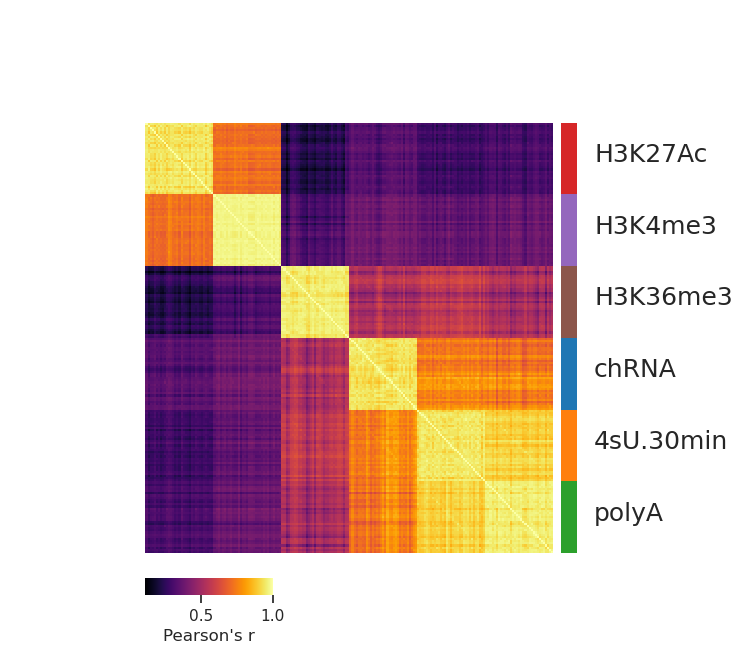

In [6]:
matrix = np.tril(pheno_corr)

# using the upper triangle matrix as mask 
# sns.heatmap(corr, annot=True, mask=matrix)

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})


col_list = plt.cm.tab10(range(10))
colores = [col_list[3]]*len(h3k27ac_logRPKM.columns)
colores += [col_list[4]]*len(h3k4me3_logRPKM.columns)
colores += [col_list[5]]*len(h3k36me3_logRPKM.columns)
colores += [col_list[0]]*len(chRNA_logRPKM.columns)
colores += [col_list[1]]*len(ml30_logRPKM.columns)
# colores += [col_list[2]]*len(ml60_logRPKM.columns)
colores += [col_list[2]]*len(polyA_logRPKM.columns)

g = sns.clustermap(pheno_corr, row_colors = colores, row_cluster=False, col_cluster=False,
              cmap='inferno', cbar_kws={'label': "Pearson's r", "orientation": "horizontal"},
                  figsize=(7.5, 7.5))#, mask=matrix, )

# g.xticks(rotation=45)

ax_ = g.ax_heatmap#.set_rotation(45)

# import matplotlib.transforms as transforms

# trans = ax_.transData.transform
# new_transform = transforms.Affine2D().rotate_deg(45)
# ax_.set_transform(new_transform + ax_.transData)


g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.tick_params(right=False, bottom=False)

n = len(pheno_corr)
m = len(h3k27ac_logRPKM.columns)
g.ax_heatmap.text(n*1.1, m-15, 'H3K27Ac', size=18, )
m += len(h3k4me3_logRPKM.columns)
g.ax_heatmap.text(n*1.1, m-15, 'H3K4me3', size=18, )
m += len(h3k36me3_logRPKM.columns)
g.ax_heatmap.text(n*1.1, m-15, 'H3K36me3', size=18,)
m += len(chRNA_logRPKM.columns)
g.ax_heatmap.text(n*1.1, m-15, 'chRNA', size=18, )
m += len(ml30_logRPKM.columns)
g.ax_heatmap.text(n*1.1, m-15, '4sU.30min', size=18,)
# m += len(ml60_logRPKM.columns)
# g.ax_heatmap.text(n*1.1, m-30, '4sU.60min', size=14, )
m += len(polyA_logRPKM.columns)
g.ax_heatmap.text(n*1.1, m-15, 'polyA', size=18, )

box_heatmap = g.ax_heatmap.get_position()
box_cbar = g.ax_cbar.get_position()

g.ax_cbar.set_position([box_heatmap.min[0], box_heatmap.max[1]-0.63, box_cbar.max[0]+0.1, 
                        box_cbar.max[0]/3])

box = g.ax_row_colors.get_position()

# g.ax_heatmap.text(0, -30, 'Protein coding genes correlation', size=18)

# g.ax_col_colors.set_position([box_heatmap.max[0], box.y0, box.width*1.5, box.height])
g.ax_row_colors.set_position([box_heatmap.max[0]+0.01, box_heatmap.min[1], box.width, box.height])


# trans = g.ax_heatmap.transData.transform
# new_transform = transforms.Affine2D().rotate_deg(45)
# g.ax_heatmap.set_transform(new_transform + g.ax_heatmap.transData)


plt.savefig('manuscript_plots/Fig1.correlation_.heatmap.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('manuscript_plots/Fig1.correlation_.heatmap.png', dpi=300, bbox_inches='tight',)
# plt.savefig('../plots/correlation.heatmap.png', dpi=300, bbox_inches='tight',)

In [7]:
polyA_samples = [x for x in pheno_corr.index if x.split('.')[0] == 'polyA']

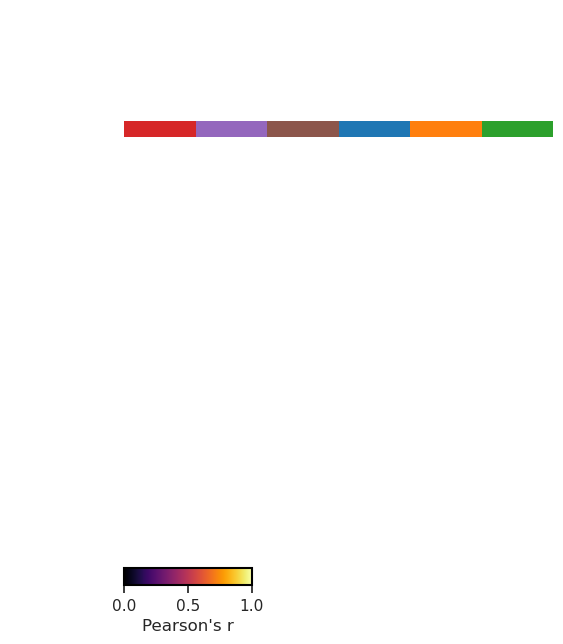

In [8]:
matrix = np.tril(pheno_corr)

# using the upper triangle matrix as mask 
# sns.heatmap(corr, annot=True, mask=matrix)

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})


col_list = plt.cm.tab10(range(10))
colores = [col_list[3]]*len(h3k27ac_logRPKM.columns)
colores += [col_list[4]]*len(h3k4me3_logRPKM.columns)
colores += [col_list[5]]*len(h3k36me3_logRPKM.columns)
colores += [col_list[0]]*len(chRNA_logRPKM.columns)
colores += [col_list[1]]*len(ml30_logRPKM.columns)
# colores += [col_list[2]]*len(ml60_logRPKM.columns)
colores += [col_list[2]]*len(polyA_logRPKM.columns)

g = sns.clustermap(pheno_corr, col_colors = colores, 
                   row_cluster=False, col_cluster=False,
              cmap='inferno', cbar_kws={'label': "Pearson's r", "orientation": "horizontal"},
                  figsize=(7.5, 7.5), vmin=0)#, mask=matrix, )

# g.xticks(rotation=45)

ax_ = g.ax_heatmap#.set_rotation(45)

g.ax_heatmap.set_visible(False)

# import matplotlib.transforms as transforms

# trans = ax_.transData.transform
# new_transform = transforms.Affine2D().rotate_deg(45)
# ax_.set_transform(new_transform + ax_.transData)


g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.tick_params(right=False, bottom=False)

# n = len(pheno_corr)
# m = len(h3k27ac_logRPKM.columns)
# g.ax_heatmap.text(m*1.08, n+20, 'H3K27Ac', size=18, rotation=-45)
# m += len(h3k4me3_logRPKM.columns)
# g.ax_heatmap.text(n*1.08, m+25, 'H3K4me3', size=18, rotation=-45)
# m += len(h3k36me3_logRPKM.columns)
# g.ax_heatmap.text(n*1.08, m+30, 'H3K36me3', size=18, rotation=-45)
# m += len(chRNA_logRPKM.columns)
# g.ax_heatmap.text(n*1.08, m+10, 'chRNA', size=18, rotation=-45)
# m += len(ml30_logRPKM.columns)
# g.ax_heatmap.text(n*1.08, m+28, '4sU.30min', size=18, rotation=-45)
# m += len(polyA_logRPKM.columns)




#g.ax_heatmap.text(n*1.08, m+10, 'polyA', size=18, rotation=-45)

box_heatmap = g.ax_heatmap.get_position()#_get_position()
box_cbar = g.ax_cbar.get_position()

# g.cax.set_visible(False)

g.ax_cbar.set_position([box_heatmap.min[0], box_heatmap.max[1]-0.59, box_cbar.max[0]+0.1, 
                        box_cbar.max[0]/3])

# # box = g.ax_col_colors.get_position() #_position()

for spine in g.ax_cbar.spines:
    g.ax_cbar.spines[spine].set_color('black')
    g.ax_cbar.spines[spine].set_linewidth(1.5)

# #
# g.ax_col_colors.set_position([box_heatmap.min[0], box_heatmap.max[0]-0.61, box.width, box.height])
# g.ax_col_colors.set_yscale(4)
# g.ax_col_colors.set_autoscaley_on(50)

# plt.show()
plt.savefig('manuscript_plots/Fig1.correlation.colorbars.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('manuscript_plots/Fig1.correlation.colorbars.png', dpi=300, bbox_inches='tight',)


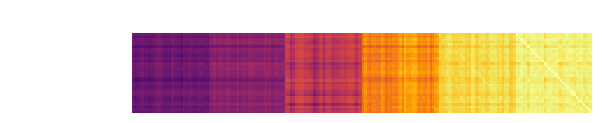

In [9]:
matrix = np.tril(pheno_corr)

# using the upper triangle matrix as mask 
# sns.heatmap(corr, annot=True, mask=matrix)

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})


col_list = plt.cm.tab10(range(10))
colores = [col_list[3]]*len(h3k27ac_logRPKM.columns)
colores += [col_list[4]]*len(h3k4me3_logRPKM.columns)
colores += [col_list[5]]*len(h3k36me3_logRPKM.columns)
colores += [col_list[0]]*len(chRNA_logRPKM.columns)
colores += [col_list[1]]*len(ml30_logRPKM.columns)
# colores += [col_list[2]]*len(ml60_logRPKM.columns)
colores += [col_list[2]]*len(polyA_logRPKM.columns)

g = sns.clustermap(pheno_corr.loc[polyA_samples], #col_colors = colores, 
                   row_cluster=False, col_cluster=False,
              cmap='inferno', cbar_kws={'label': "Pearson's r", "orientation": "horizontal"},
                  figsize=(7.5, 3.1), vmin=0)#, mask=matrix, )

# g.xticks(rotation=45)

ax_ = g.ax_heatmap#.set_rotation(45)

# import matplotlib.transforms as transforms

# trans = ax_.transData.transform
# new_transform = transforms.Affine2D().rotate_deg(45)
# ax_.set_transform(new_transform + ax_.transData)


g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.tick_params(right=False, bottom=False)

# n = len(pheno_corr)
# m = len(h3k27ac_logRPKM.columns)
# g.ax_heatmap.text(m*1.08, n+20, 'H3K27Ac', size=18, rotation=-45)
# m += len(h3k4me3_logRPKM.columns)
# g.ax_heatmap.text(n*1.08, m+25, 'H3K4me3', size=18, rotation=-45)
# m += len(h3k36me3_logRPKM.columns)
# g.ax_heatmap.text(n*1.08, m+30, 'H3K36me3', size=18, rotation=-45)
# m += len(chRNA_logRPKM.columns)
# g.ax_heatmap.text(n*1.08, m+10, 'chRNA', size=18, rotation=-45)
# m += len(ml30_logRPKM.columns)
# g.ax_heatmap.text(n*1.08, m+28, '4sU.30min', size=18, rotation=-45)
# m += len(polyA_logRPKM.columns)




#g.ax_heatmap.text(n*1.08, m+10, 'polyA', size=18, rotation=-45)

box_heatmap = g.ax_heatmap.get_position()#_get_position()
box_cbar = g.ax_cbar.get_position()

g.cax.set_visible(False)

# g.ax_cbar.set_position([box_heatmap.min[0], box_heatmap.max[1]-0.59, box_cbar.max[0]+0.1, 
#                         box_cbar.max[0]/3])

# # box = g.ax_col_colors.get_position() #_position()

# #
# g.ax_col_colors.set_position([box_heatmap.min[0], box_heatmap.max[0]-0.61, box.width, box.height])
# g.ax_col_colors.set_yscale(4)
# g.ax_col_colors.set_autoscaley_on(50)

# plt.show()
plt.savefig('manuscript_plots/Fig1.correlation.heatmap_polyA.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('manuscript_plots/Fig1.correlation.heatmap_polyA.png', dpi=300, bbox_inches='tight',)


In [10]:
h3k36me3_last3k = pd.read_csv(
    "../code/QTLs/QTLTools/H3K36ME3/OnlyFirstRepsUnstandardized.Last3K.qqnorm.bed.gz", 
    sep='\t', index_col=3)

h3k36me3_encode = pd.read_csv(
    "../code/QTLs/QTLTools/H3K36ME3/OnlyFirstRepsUnstandardized.Encode.qqnorm.bed.gz", 
    sep='\t', index_col=3)

all_h3k36 = pd.concat([h3k27ac_logRPKM.iloc[:,6:10],
                       h3k4me3_logRPKM.iloc[:,6:10],
                       h3k36me3[shared_samples].iloc[:,6:10], 
                       h3k36me3_encode[['GM12878.1', 'GM12878.2',
                                        'GM06990.1', 'GM06990.2']],
                       chRNA_logRPKM.iloc[:,6:10],
                       ml30_logRPKM.iloc[:,6:10],
                       polyA_logRPKM.iloc[:,6:10],
                      ], axis=1)

pheno_corr = all_h3k36.corr(method='spearman')

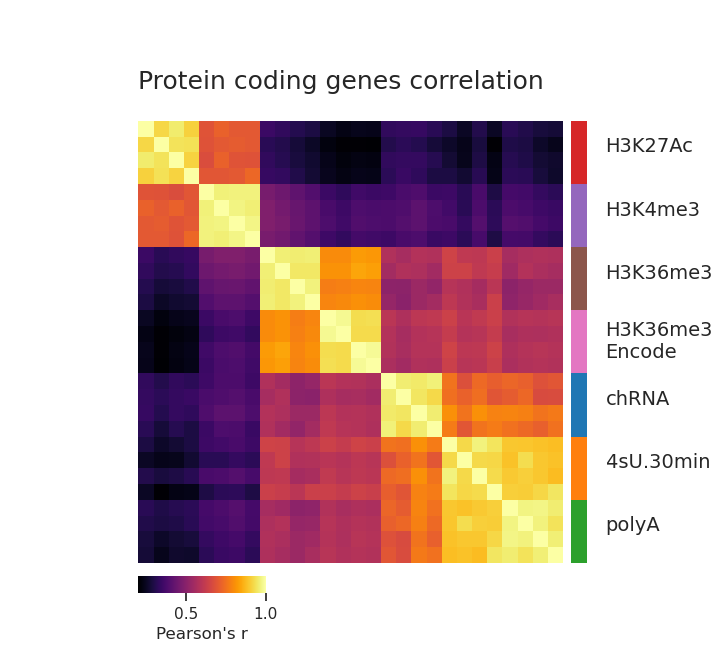

In [11]:
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})


col_list = plt.cm.tab10(range(10))
colores = [col_list[3]]*4
colores += [col_list[4]]*4
colores += [col_list[5]]*4
colores += [col_list[6]]*4
colores += [col_list[0]]*4
colores += [col_list[1]]*4
colores += [col_list[2]]*4



g = sns.clustermap(pheno_corr, row_colors = colores, row_cluster=False, col_cluster=False,
              cmap='inferno', cbar_kws={'label': "Pearson's r", "orientation": "horizontal"},
                  figsize=(7.5, 7.5))


g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.tick_params(right=False, bottom=False)

n = len(pheno_corr)
m = 4
g.ax_heatmap.text(n*1.1, m-2, 'H3K27Ac', size=14, )
m += 4
g.ax_heatmap.text(n*1.1, m-2, 'H3K4me3', size=14, )
m += 4
g.ax_heatmap.text(n*1.1, m-2, 'H3K36me3', size=14,)
m += 4
g.ax_heatmap.text(n*1.1, m-1, 'H3K36me3\nEncode', size=14,)
m += 4
g.ax_heatmap.text(n*1.1, m-2, 'chRNA', size=14, )
m += 4
g.ax_heatmap.text(n*1.1, m-2, '4sU.30min', size=14,)
m += 4
g.ax_heatmap.text(n*1.1, m-2, 'polyA', size=14, )

box_heatmap = g.ax_heatmap.get_position()
box_cbar = g.ax_cbar.get_position()

g.ax_cbar.set_position([box_heatmap.min[0], box_heatmap.max[1]-0.63, box_cbar.max[0]+0.1, 
                        box_cbar.max[0]/3])

box = g.ax_row_colors.get_position()

g.ax_heatmap.text(0, -2, 'Protein coding genes correlation', size=18)

# g.ax_col_colors.set_position([box_heatmap.max[0], box.y0, box.width*1.5, box.height])
g.ax_row_colors.set_position([box_heatmap.max[0]+0.01, box_heatmap.min[1], box.width, box.height])

plt.savefig('manuscript_plots/Fig1.correlation.heatmap_small.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('manuscript_plots/Fig1.correlation.heatmap_small.png', dpi=300, bbox_inches='tight',)
# plt.savefig('../plots/correlation.heatmap.png', dpi=300, bbox_inches='tight',)

In [12]:
gtf = pd.read_csv('../../genes.annotation.tab.gz', sep='\t', index_col=0, names = ['annotation'])

In [13]:
chRNA = pd.read_csv('QTLs/QTLTools/chRNA.Expression.Splicing/OnlyFirstRepsUnstandardized.AllGenes.qqnorm.bed.gz', 
                    sep='\t', index_col=0)

chRNA.columns = ['chRNA.' + x for x in chRNA.columns]

ml30 = pd.read_csv('QTLs/QTLTools/MetabolicLabelled.30min/OnlyFirstRepsUnstandardized.AllGenes.qqnorm.bed.gz', 
                    sep='\t', index_col=0)

ml30.columns = ['ml30.' + x for x in ml30.columns]


polyA = pd.read_csv('QTLs/QTLTools/Expression.Splicing.Subset_YRI/OnlyFirstRepsUnstandardized.AllGenes.qqnorm.bed.gz', 
                    sep='\t', index_col=0)

polyA.columns = ['polyA.' + x for x in polyA.columns]


In [14]:
all_rnas = pd.concat([chRNA, ml30, polyA], axis=1)

In [15]:
gene_list = pd.read_csv('ExpressionAnalysis/polyA/ExpressedGeneList.txt', sep='\t',
                        names = ['chrom', 'start', 'end', 'gene', 'score', 'strand'])
expressed_genes = pd.Index(list(gene_list.gene))

In [16]:
pseudogenes = gtf.loc[['pseudogene' in x for x in gtf.annotation]].index
lncRNAs = gtf.loc[['lncRNA' in x for x in gtf.annotation]].index
snoRNAs = gtf.loc[['snoRNA' in x for x in gtf.annotation]].index

expressed_pseudogenes = all_rnas.loc[pseudogenes].loc[all_rnas.loc[pseudogenes, chRNA.columns].mean(axis=1) >= 1].index
expressed_lncRNAs = all_rnas.loc[lncRNAs].loc[all_rnas.loc[lncRNAs, chRNA.columns].mean(axis=1) >= 1].index

expressed_snoRNAs = all_rnas.loc[snoRNAs].loc[all_rnas.loc[snoRNAs, chRNA.columns].mean(axis=1) >= 1].index

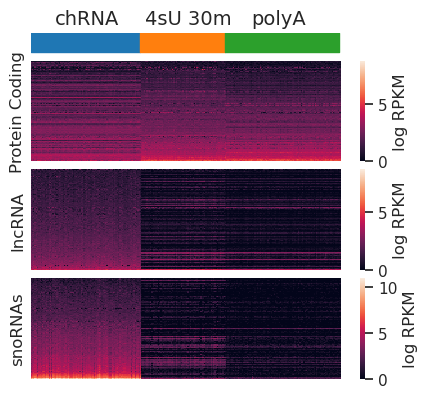

In [17]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(figsize = (5,4.5), nrows=4, 
                                                   gridspec_kw={'height_ratios': [1, 5, 5, 5]})
fig.subplots_adjust(hspace=0.1)

ax0.set_yticks([])
ax1.set_yticks([])


ax0.set_xticks([])
ax1.set_xticks([])


ax0.spines["right"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)


s1 = len(chRNA.columns)
s2 = len(ml30.columns) + s1
# s3 = len(ml60.columns) + s2
s3 = len(polyA.columns) + s2
# s5 = len(ProCap_RPKM.columns) + s4
colores = list(plt.get_cmap('tab10').colors)

ax0.fill_between(np.array([0, s1])*.795, [0, 0], [1, 1], color=colores[0])
ax0.fill_between(np.array([s1, s2])*.795, [0, 0], [1, 1], color=colores[1])
ax0.fill_between(np.array([s2, s3])*.795, [0, 0], [1, 1], color=colores[2])

ax0.set_xlim([0, s3])

expression_genes_plot = all_rnas.loc[expressed_genes,].quantile(0.5, axis=1).sort_values().index[-10000:]

sns.heatmap(all_rnas.loc[expression_genes_plot], ax=ax1, 
            cbar_kws={'label': "log RPKM"})

expressed_lncRNAs_plot = all_rnas.loc[expressed_lncRNAs, chRNA.columns].quantile(0.5, axis=1).sort_values().index

sns.heatmap(all_rnas.loc[expressed_lncRNAs_plot], ax=ax2, 
            cbar_kws={'label': "log RPKM"})

# expressed_pseudogenes_plot = all_rnas.loc[expressed_lncRNAs, chRNA.columns].quantile(0.5, axis=1).sort_values().index
# sns.heatmap(all_rnas.loc[expressed_pseudogenes_plot], ax=ax3, 
#             cbar_kws={'label': "log RPKM"})

expressed_snoRNAs_plot = all_rnas.loc[expressed_snoRNAs, chRNA.columns].quantile(0.5, axis=1).sort_values().index
sns.heatmap(all_rnas.loc[expressed_snoRNAs_plot], ax=ax3, 
            cbar_kws={'label': "log RPKM"})

for ax in [ax0, ax1, ax2, ax3]:
    ax.set_xticks([])
    ax.set_yticks([])
    
ax1.set_ylabel('Protein Coding')
ax2.set_ylabel('lncRNA')
# ax3.set_ylabel('Other ncRNA')
# ax3.set_ylabel('pseudogenes')
ax3.set_ylabel('snoRNAs')



ax0.text(15, 1.5, 'chRNA', size=14)
ax0.text(s1-15, 1.5, '4sU 30m', size=14)
ax0.text(s2-15, 1.5, 'polyA', size=14)


plt.savefig('manuscript_plots/Fig1.heatmap_RNA.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('manuscript_plots/Fig1.heatmap_RNA.png', dpi=300, bbox_inches='tight',)

# plt.savefig('../plots/heatmap_RNA.png', dpi=500, transparent=True)

# g.ax_cbar.set_position([box_heatmap.min[0], box_heatmap.max[1]-0.78, box_cbar.max[0]+0.1, box_cbar.max[0]/3])